In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('src/data.csv')
df.head()

,Unnamed: 0,image,classes
0,0,image/0.jpeg,critical
1,1,image/1.jpeg,head_lamp
2,2,image/2.jpeg,door_scratch
3,3,image/3.jpeg,head_lamp
4,4,image/4.jpeg,good


## Imports

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import os
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import ColorJitter


## Step 1 - Load Data

Use the cell below (or make additional cells) to load a torch Dataset and use a torch DataLoader to access it. You may use any dataset you like, as long as it is imagery (since this assignment is focused on image transforms). Datasets built into PyTorch may be used.

**0.25 points extra credit will be awarded for implementing a custom Dataset.** Be sure to pick a dataset you have the capacity to train a model on in your development environment. To keep the assignment fair grading will not be based on the size of the dataset used in any way. Plot a few of the images to ensure you have loaded the data correctly.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


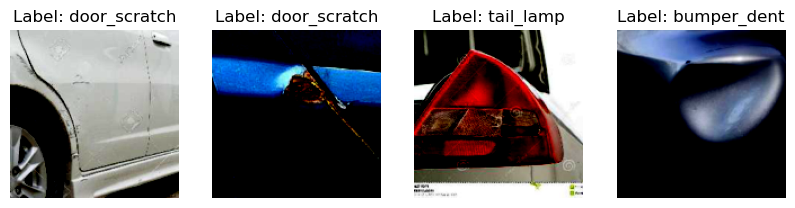

In [10]:


# Directory containing images
img_directory = 'renamed_images/'

# Define transformations
img_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom dataset class
class FlowerImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_list = [file for file in os.listdir(directory) if file.endswith('.jpeg')]
        self.categories = sorted({"_".join(file.split('_')[:-1]) for file in self.image_list})
        self.category_to_idx = {category: idx for idx, category in enumerate(self.categories)}
        self.total_classes = len(self.categories)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img_file = self.image_list[index]
        img_path = os.path.join(self.directory, img_file)
        
        # Load image and apply transformations
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        # Extract label from file name
        label_name = "_".join(img_file.split('_')[:-1])
        label = self.category_to_idx[label_name]

        return img, label

# Initialize dataset
flower_dataset = FlowerImageDataset(directory=img_directory, transform=img_transforms)

# Split dataset into training and testing sets
train_length = int(0.8 * len(flower_dataset))
test_length = len(flower_dataset) - train_length
train_data, test_data = random_split(flower_dataset, [train_length, test_length])

# DataLoaders for train and test
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Display sample images with labels
sample_iter = iter(train_loader)
sample_images, sample_labels = next(sample_iter)

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for idx, (image, label) in enumerate(zip(sample_images, sample_labels)):
    img_display = image.permute(1, 2, 0)  # Adjust for display
    axes[idx].imshow(img_display.numpy())
    axes[idx].set_title(f'Label: {flower_dataset.categories[label]}')
    axes[idx].axis('off')
plt.show()


## Step 2 - Define Training Pipeline

Define a training pipeline like those we have seen in class. Define the class which specifies our neural network architecture, and to define the functions which allow us to train it. We have seen examples of this before, both in class and prior assignments.

Be sure to chose an architecture with sufficient capacity to learn the dataset you have chosen in step #1.

Tip: if you see your architecture is insufficient to learn the dataset you have chosen when you run step 3, you may need to return to step #2 to make your architecture wider or deeper.

In [12]:

# Define the number of classes from the dataset
num_labels = flower_dataset.total_classes

# CNN model class for small images
class CompactCNNModel(nn.Module):
    def __init__(self, num_labels):
        super(CompactCNNModel, self).__init__()
        
        # Convolutional layers with batch normalization and max-pooling
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input channels: 3, output channels: 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16 input channels, 32 output channels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 input channels, 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
        )

        # Calculate the flattened size for fully connected layers
        with torch.no_grad():
            dummy_tensor = torch.zeros(1, 3, 150, 150)  # Example input size (batch=1)
            flattened_dim = self.conv_stack(dummy_tensor).numel()

        # Fully connected layers with dropout
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.13),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_labels)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x

# Instantiate the model with the number of classes
cnn_model = CompactCNNModel(num_labels)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [14]:
def train_neural_net(model, data_loader, loss_fn, optim_func, max_epochs=30, early_stop_patience=3):
    model.train()  # Set the model to training mode
    min_loss = float('inf')  
    stagnant_epochs = 0  # Counter for epochs with no improvement
    loss_history = []
    accuracy_history = []  

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        correct_count = 0  
        total_count = 0  

        # Iterate through batches
        for batch_images, batch_labels in data_loader:
            optim_func.zero_grad()  # Clear gradients
            predictions = model(batch_images)  # Forward pass

            loss_value = loss_fn(predictions, batch_labels)  # Calculate loss
            loss_value.backward()  # Backpropagate loss
            optim_func.step()  # Update weights
            
            epoch_loss += loss_value.item()  # Accumulate loss for this epoch
            
            # Calculate accuracy
            _, max_indices = predictions.max(1)  # Get predictions
            correct_count += max_indices.eq(batch_labels).sum().item()  
            total_count += batch_labels.size(0)  
        
        # Calculate average loss and accuracy for the epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        loss_history.append(avg_epoch_loss)

        epoch_accuracy = 100 * correct_count / total_count
        accuracy_history.append(epoch_accuracy)
        
        print(f'Epoch {epoch + 1}/{max_epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        # Early stopping logic
        if avg_epoch_loss < min_loss:
            min_loss = avg_epoch_loss
            stagnant_epochs = 0  
        else:
            stagnant_epochs += 1  

        if stagnant_epochs >= early_stop_patience and epoch > 10:
            print(f'Early stopping triggered at epoch {epoch + 1} after {early_stop_patience} stagnant epochs.')
            break
            
    return loss_history, accuracy_history  


## Step 3 - Train a Model

Kick off your training run here. Be sure to print or plot the error wrt. number of epochs so you can see if your model is learning.


Epoch 1/10, Loss: 2.0333, Accuracy: 25.25%
Epoch 2/10, Loss: 1.7655, Accuracy: 35.26%
Epoch 3/10, Loss: 1.6084, Accuracy: 41.89%
Epoch 4/10, Loss: 1.4523, Accuracy: 48.01%
Epoch 5/10, Loss: 1.3393, Accuracy: 52.24%
Epoch 6/10, Loss: 1.2074, Accuracy: 56.62%
Epoch 7/10, Loss: 1.0502, Accuracy: 64.07%
Epoch 8/10, Loss: 0.9128, Accuracy: 67.72%
Epoch 9/10, Loss: 0.7841, Accuracy: 73.43%
Epoch 10/10, Loss: 0.6416, Accuracy: 77.73%


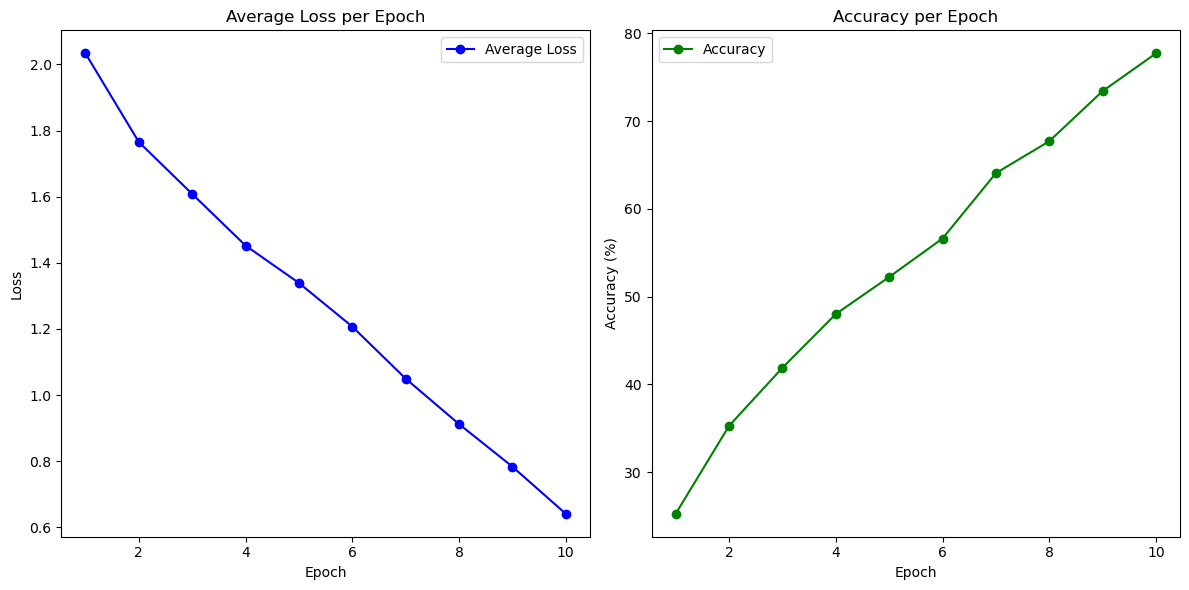

In [17]:
# Train the model and gather loss and accuracy results
loss_over_epochs, acc_over_epochs = train_neural_net(cnn_model, train_loader, loss_fn, optimizer, max_epochs=10)

# Plotting Average Loss and Accuracy over Epochs
plt.figure(figsize=(12, 6))

# Plotting the Average Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_over_epochs) + 1), loss_over_epochs, marker='o', color='blue', label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss per Epoch')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_over_epochs) + 1), acc_over_epochs, marker='o', color='green', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Step 4 - Use Transforms to Robustness Test the Model Against Image Blur

Use the cell below (or add more cells), to write code which repeatedly (e.g., in a for-loop) infers your model on your test set. Each time you do so, apply a blur transform with an increasing amount of blur. Compute and save the average accuracy across the entire test set and then plot the accuracy against the degree of blur (choose and appropriate metric for the degree of blur). The end result of this step should be a plot of accuracy with respect to degree of blur. Be sure to test the model **to failure** to fully characterize its limitations.


Blur Sigma: 1, Accuracy: 28.0654
Blur Sigma: 3, Accuracy: 22.7520
Blur Sigma: 5, Accuracy: 23.0245
Blur Sigma: 7, Accuracy: 23.2970
Blur Sigma: 9, Accuracy: 23.1608
Blur Sigma: 11, Accuracy: 23.0245
Blur Sigma: 13, Accuracy: 22.8883
Blur Sigma: 15, Accuracy: 23.0245
Blur Sigma: 17, Accuracy: 22.8883
Blur Sigma: 19, Accuracy: 22.8883
Blur Sigma: 21, Accuracy: 22.7520
Blur Sigma: 23, Accuracy: 22.6158
Blur Sigma: 25, Accuracy: 22.6158
Blur Sigma: 27, Accuracy: 22.7520
Blur Sigma: 29, Accuracy: 22.6158
Blur Sigma: 31, Accuracy: 22.6158
Blur Sigma: 33, Accuracy: 22.6158
Blur Sigma: 35, Accuracy: 22.6158
Blur Sigma: 37, Accuracy: 22.7520
Blur Sigma: 39, Accuracy: 22.6158


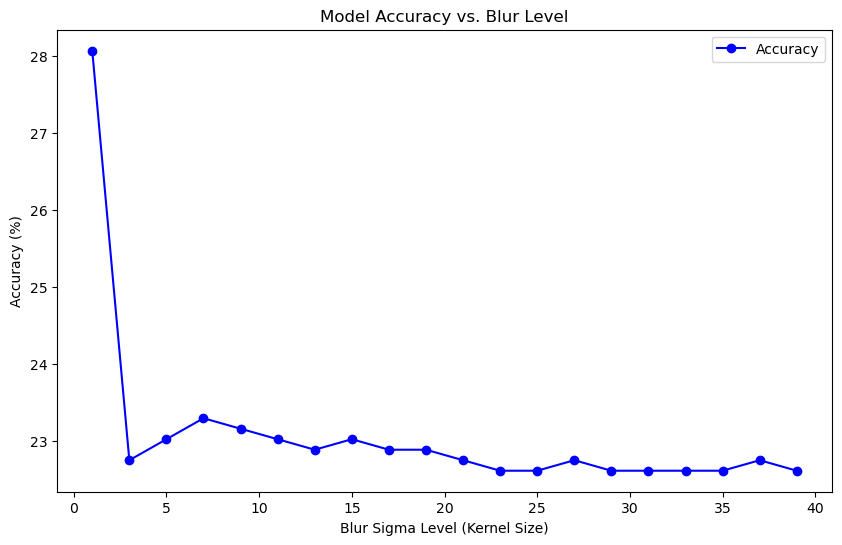

In [6]:
# Set device and move model to appropriate device
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_model.to(compute_device)

def assess_blur_resilience(model, data_loader, max_blur_sigma=3):
    model.eval()  
    accuracy_per_blur_level = []
    blur_sigma_values = range(1, max_blur_sigma * 2, 2) 

    for sigma_value in blur_sigma_values:
        total_correct = 0
        sample_count = 0

        # Define blur transformation with variable sigma
        blur_augmentation = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.GaussianBlur(kernel_size=(21, 21), sigma=sigma_value),
            transforms.ToTensor()
        ])

        # Perform evaluation without gradient tracking
        with torch.no_grad():
            for batch_images, batch_labels in data_loader:
                # Apply blur transformation on each image in the batch
                augmented_images = torch.stack([
                    blur_augmentation(transforms.ToPILImage()(img)) for img in batch_images
                ])
                augmented_images, batch_labels = augmented_images.to(compute_device), batch_labels.to(compute_device)
                
                # Make predictions and evaluate accuracy
                predictions = model(augmented_images)
                _, predicted_classes = torch.max(predictions, 1)
                sample_count += batch_labels.size(0)
                total_correct += (predicted_classes == batch_labels).sum().item()

        # Calculate and store accuracy for the current blur level
        accuracy = 100 * (total_correct / sample_count)
        accuracy_per_blur_level.append(accuracy)
        print(f'Blur Sigma: {sigma_value}, Accuracy: {accuracy:.4f}')

    return blur_sigma_values, accuracy_per_blur_level

# Evaluate model robustness across various blur levels
blur_sigma_values, accuracy_metrics = assess_blur_resilience(model, test_loader, max_blur_sigma=20)

# Plotting Accuracy vs. Blur Levels
plt.figure(figsize=(10, 6))
plt.plot(blur_sigma_values, accuracy_metrics, marker='o', color='blue', label='Accuracy')
plt.xlabel('Blur Sigma Level (Kernel Size)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Blur Level')
plt.legend()
plt.show()


## Step 5 - Robustness Test the Model Against a Transform of Your Choice

Repeat step 4 for a transform of your choice. Create a plot showing how model accuracy degrades as the transform is applied more drastically.


Brightness Level: 0.0, Accuracy: 31.4714
Brightness Level: 0.1, Accuracy: 31.1989
Brightness Level: 0.2, Accuracy: 31.8801
Brightness Level: 0.3, Accuracy: 32.6975
Brightness Level: 0.4, Accuracy: 30.7902
Brightness Level: 0.5, Accuracy: 28.0654
Brightness Level: 0.6, Accuracy: 30.9264
Brightness Level: 0.7, Accuracy: 29.5640
Brightness Level: 0.8, Accuracy: 28.8828
Brightness Level: 0.9, Accuracy: 26.9755
Brightness Level: 1.0, Accuracy: 27.3842
Brightness Level: 1.1, Accuracy: 28.8828
Brightness Level: 1.2, Accuracy: 27.3842
Brightness Level: 1.3, Accuracy: 27.6567
Brightness Level: 1.4, Accuracy: 25.4768
Brightness Level: 1.5, Accuracy: 26.8392
Brightness Level: 1.6, Accuracy: 28.3379
Brightness Level: 1.7, Accuracy: 26.7030
Brightness Level: 1.8, Accuracy: 28.4741
Brightness Level: 1.9, Accuracy: 26.7030
Brightness Level: 2.0, Accuracy: 26.1580
Brightness Level: 2.1, Accuracy: 27.9292
Brightness Level: 2.2, Accuracy: 26.8392
Brightness Level: 2.3, Accuracy: 26.7030
Brightness Level

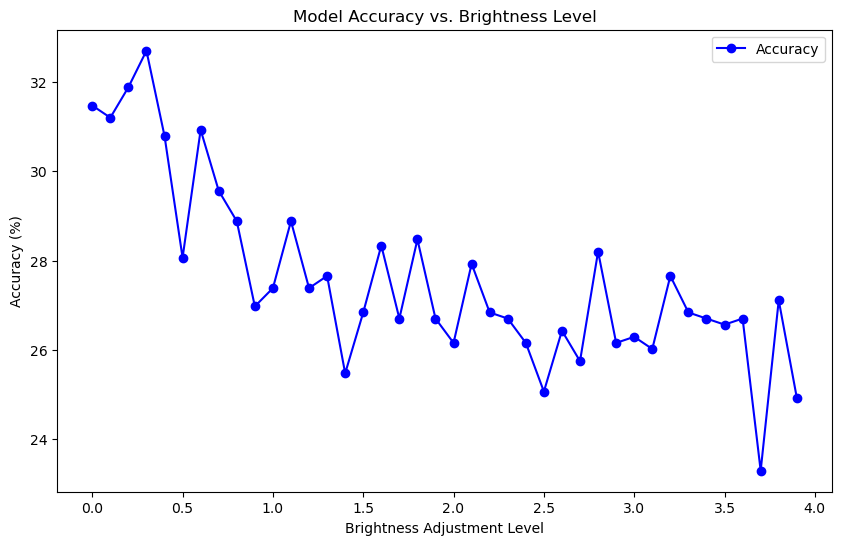

In [7]:
def assess_brightness_resilience(model, data_loader):
    model.eval()  
    accuracy_per_brightness = []
    brightness_variations = [round(0.1 * i, 1) for i in range(40)]

    for brightness_level in brightness_variations:
        total_correct = 0
        sample_count = 0

        # Define brightness adjustment transformation
        brightness_adjustment = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.ColorJitter(brightness=brightness_level),
            transforms.ToTensor()
        ])

        # Evaluate model with different brightness levels
        with torch.no_grad():
            for batch_images, batch_labels in data_loader:
                adjusted_images = torch.stack([
                    brightness_adjustment(transforms.ToPILImage()(img)) for img in batch_images
                ])
                adjusted_images, batch_labels = adjusted_images.to(compute_device), batch_labels.to(compute_device)
                
                # Make predictions and count correct predictions
                predictions = model(adjusted_images)
                _, predicted_classes = torch.max(predictions, 1)
                sample_count += batch_labels.size(0)
                total_correct += (predicted_classes == batch_labels).sum().item()

        # Calculate and store accuracy for each brightness level
        accuracy = 100 * (total_correct / sample_count)
        accuracy_per_brightness.append(accuracy)
        print(f'Brightness Level: {brightness_level}, Accuracy: {accuracy:.4f}')

    return brightness_variations, accuracy_per_brightness

# Evaluating model robustness across brightness variations
brightness_values, accuracy_scores = assess_brightness_resilience(cnn_model, test_loader)

# Plot Accuracy vs. Brightness Levels
plt.figure(figsize=(10, 6))
plt.plot(brightness_values, accuracy_scores, marker='o', color='blue', label='Accuracy')
plt.xlabel('Brightness Adjustment Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Brightness Level')
plt.legend()
plt.show()
